<a href="https://colab.research.google.com/github/tevfik-erkut/ML_mixture/blob/main/NN%2BARIMA%2BSVM%2BLSTM_Time_Series_Forecasting_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries & Reading Data

In [6]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools

import sys 
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.metrics import mean_squared_error,r2_score
## Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers import Dropout

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("/content/data-2.csv", delimiter = ";")

### Let's take a look at our dataframe!

In [7]:
df.head()

,locationId,location,Date,Time,PM25,PM10,latitude,longitude
0,10519,GR0048A,31/12/2021,0:00,28.0,36.0,3.824.597.549,2.173.589.706
1,10519,GR0048A,30/12/2021,23:00,28.0,35.0,3.824.597.549,2.173.589.706
2,10519,GR0048A,30/12/2021,22:00,18.0,22.0,3.824.597.549,2.173.589.706
3,10519,GR0048A,30/12/2021,21:00,15.0,26.0,3.824.597.549,2.173.589.706
4,10519,GR0048A,30/12/2021,20:00,11.0,17.0,3.824.597.549,2.173.589.706


We won't need locationId, location, latitude, longitude. Therefore I am dropping them.

In [8]:
df  = df.drop(["locationId", "location", "latitude", "longitude"], 1)

In [9]:
df.Date = pd.to_datetime(df.Date)
df = df.sort_values("Date")

In [10]:
df = df.reset_index(drop = True)

In [11]:
pm_25 = df["PM25"]
pm_10 = df["PM10"]

#### Let's start with PM25! First, LSTM

I am creating a function for our LSTM model to work better. ( with shift method )

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Scaling..

In [13]:
from sklearn.preprocessing import MinMaxScaler
values = pm_25.values.tolist()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(np.array(values).reshape(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)   var1(t)
1   0.010011  0.006674
2   0.006674  0.007786
3   0.007786  0.006674
4   0.006674  0.005562
5   0.005562  0.005562


In [14]:
# split into train and test sets
values = reframed.values

n_train_time = 11086
train = values[:n_train_time, :]
test = values[n_train_time:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(11086, 1, 1) (11086,) (1, 1, 1) (1,)


In [ ]:
values.shape

(11126, 2)

Epoch 1/5
693/693 - 5s - loss: 5.7794e-04 - val_loss: 2.3662e-06 - 5s/epoch - 7ms/step
Epoch 2/5
693/693 - 2s - loss: 5.7006e-04 - val_loss: 1.7574e-06 - 2s/epoch - 2ms/step
Epoch 3/5
693/693 - 2s - loss: 5.6730e-04 - val_loss: 2.3825e-06 - 2s/epoch - 2ms/step
Epoch 4/5
693/693 - 2s - loss: 5.6503e-04 - val_loss: 3.0737e-06 - 2s/epoch - 2ms/step
Epoch 5/5
693/693 - 2s - loss: 5.6294e-04 - val_loss: 4.0544e-06 - 2s/epoch - 3ms/step


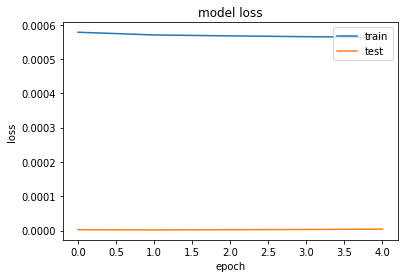

In [15]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.02))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Let's check the results

In [18]:
pm_25_lstm_result = mean_squared_error(np.array([inv_y[-1]]), np.array([inv_yhat[-1]]))
pm_25_lstm_result

3.27677697779759

### LSTM Model for PM10

In [19]:
values = pm_10.values.tolist()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(np.array(values).reshape(-1,1))
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

print(reframed.head())

   var1(t-1)   var1(t)
1   0.019451  0.022883
2   0.022883  0.016018
3   0.016018  0.019451
4   0.019451  0.017162
5   0.017162  0.009153


In [20]:
# split into train and test sets
values = reframed.values

n_train_time = 11086
train = values[:n_train_time, :]
test = values[n_train_time:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(11086, 1, 1) (11086,) (29, 1, 1) (29,)


Epoch 1/5
693/693 - 4s - loss: 0.0013 - val_loss: 8.6102e-04 - 4s/epoch - 6ms/step
Epoch 2/5
693/693 - 2s - loss: 0.0013 - val_loss: 8.4868e-04 - 2s/epoch - 2ms/step
Epoch 3/5
693/693 - 2s - loss: 0.0013 - val_loss: 8.4730e-04 - 2s/epoch - 3ms/step
Epoch 4/5
693/693 - 4s - loss: 0.0013 - val_loss: 8.3637e-04 - 4s/epoch - 5ms/step
Epoch 5/5
693/693 - 4s - loss: 0.0013 - val_loss: 8.2453e-04 - 4s/epoch - 5ms/step


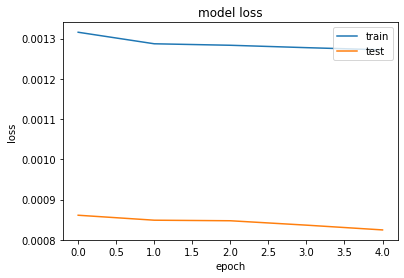

In [21]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.15))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=5, batch_size=16, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [22]:
pm_10_lstm_result = mean_squared_error(np.array([inv_y[-1]]), np.array([inv_yhat[-1]]))

In [23]:
pm_10_lstm_result

7.684700634167923

### Hybrid MODEL for PM25

In [55]:
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()
    # Input sequence (t-n, ... t-1)
    for i in range(window, 0, -1):
        cols.append(data.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]
    # Current timestep (t=0)
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]
    # Target timestep (t=lag)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]
    # Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [56]:
window = 30
lag = 1
series = series_to_supervised(pm_25.to_frame(), window=window, lag=lag)
series.head()

,PM25(t-30),PM25(t-29),PM25(t-28),PM25(t-27),PM25(t-26),PM25(t-25),PM25(t-24),PM25(t-23),PM25(t-22),PM25(t-21),...,PM25(t-8),PM25(t-7),PM25(t-6),PM25(t-5),PM25(t-4),PM25(t-3),PM25(t-2),PM25(t-1),PM25(t),PM25(t+1)
30,9.0,6.0,7.0,6.0,5.0,5.0,5.0,3.0,2.0,3.0,...,4.0,2.0,5.0,6.0,4.0,5.0,10.0,3.0,5.0,11.0
31,6.0,7.0,6.0,5.0,5.0,5.0,3.0,2.0,3.0,8.0,...,2.0,5.0,6.0,4.0,5.0,10.0,3.0,5.0,11.0,7.0
32,7.0,6.0,5.0,5.0,5.0,3.0,2.0,3.0,8.0,7.0,...,5.0,6.0,4.0,5.0,10.0,3.0,5.0,11.0,7.0,4.0
33,6.0,5.0,5.0,5.0,3.0,2.0,3.0,8.0,7.0,5.0,...,6.0,4.0,5.0,10.0,3.0,5.0,11.0,7.0,4.0,7.0
34,5.0,5.0,5.0,3.0,2.0,3.0,8.0,7.0,5.0,3.0,...,4.0,5.0,10.0,3.0,5.0,11.0,7.0,4.0,7.0,15.0


In [57]:
labels_col = 'PM25(t+%d)' % 1
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

In [58]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.00006, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (10781, 31)
Validation set shape (1, 31)


,PM25(t-30),PM25(t-29),PM25(t-28),PM25(t-27),PM25(t-26),PM25(t-25),PM25(t-24),PM25(t-23),PM25(t-22),PM25(t-21),...,PM25(t-9),PM25(t-8),PM25(t-7),PM25(t-6),PM25(t-5),PM25(t-4),PM25(t-3),PM25(t-2),PM25(t-1),PM25(t)
6318,14.0,18.0,28.0,10.0,5.0,37.0,37.0,25.0,10.0,11.0,...,13.0,14.0,17.0,21.0,15.0,15.0,14.0,10.0,9.0,28.0
8153,29.0,30.0,13.0,16.0,17.0,19.0,16.0,35.0,28.0,33.0,...,10.0,16.0,40.0,19.0,59.0,9.0,9.0,39.0,7.0,57.0
3920,24.0,9.0,9.0,6.0,8.0,6.0,7.0,6.0,28.0,7.0,...,11.0,5.0,4.0,7.0,12.0,19.0,20.0,3.0,12.0,7.0
4467,32.0,16.0,5.0,6.0,8.0,14.0,11.0,15.0,12.0,12.0,...,58.0,69.0,61.0,17.0,19.0,22.0,21.0,20.0,68.0,40.0
4304,48.0,61.0,10.0,16.0,6.0,49.0,16.0,7.0,7.0,6.0,...,8.0,14.0,10.0,11.0,8.0,8.0,10.0,13.0,6.0,13.0


In [59]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (10781, 31, 1)
Validation set shape (1, 31, 1)


In [60]:

from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")

In [61]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10781, 1, 31, 1)
Validation set shape (1, 1, 31, 1)


In [62]:
from tensorflow.keras.optimizers import Adam

In [63]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3]))) #cnn layer
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu')) #lstm layer
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer= "Adam")

In [64]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=20, verbose=2)

Epoch 1/20
337/337 - 4s - loss: 406.0860 - val_loss: 9.3853 - 4s/epoch - 12ms/step
Epoch 2/20
337/337 - 3s - loss: 391.0055 - val_loss: 63.5638 - 3s/epoch - 8ms/step
Epoch 3/20
337/337 - 3s - loss: 390.1869 - val_loss: 54.7674 - 3s/epoch - 10ms/step
Epoch 4/20
337/337 - 3s - loss: 386.9506 - val_loss: 47.5075 - 3s/epoch - 8ms/step
Epoch 5/20
337/337 - 3s - loss: 386.5783 - val_loss: 47.2097 - 3s/epoch - 9ms/step
Epoch 6/20
337/337 - 3s - loss: 386.8528 - val_loss: 30.3277 - 3s/epoch - 10ms/step
Epoch 7/20
337/337 - 3s - loss: 385.9542 - val_loss: 101.5656 - 3s/epoch - 8ms/step
Epoch 8/20
337/337 - 3s - loss: 388.5033 - val_loss: 25.7741 - 3s/epoch - 9ms/step
Epoch 9/20
337/337 - 3s - loss: 384.3687 - val_loss: 12.1543 - 3s/epoch - 10ms/step
Epoch 10/20
337/337 - 3s - loss: 384.2910 - val_loss: 45.2931 - 3s/epoch - 9ms/step
Epoch 11/20
337/337 - 3s - loss: 384.7852 - val_loss: 37.0131 - 3s/epoch - 10ms/step
Epoch 12/20
337/337 - 2s - loss: 384.7879 - val_loss: 62.0856 - 2s/epoch - 7ms/s

In [65]:
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
pm_25_hybrid_result = np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred))
print('Validation rmse:', pm_25_hybrid_result)

Validation rmse: 5.5088043212890625


### Hybrid Model with PM10

In [46]:
window = 30
lag = 1
series = series_to_supervised(pm_10.to_frame(), window=window, lag=lag)
series.head()

labels_col = 'PM10(t+%d)' % 1
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

In [47]:
X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.00006, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (10994, 31)
Validation set shape (1, 31)


,PM10(t-30),PM10(t-29),PM10(t-28),PM10(t-27),PM10(t-26),PM10(t-25),PM10(t-24),PM10(t-23),PM10(t-22),PM10(t-21),...,PM10(t-9),PM10(t-8),PM10(t-7),PM10(t-6),PM10(t-5),PM10(t-4),PM10(t-3),PM10(t-2),PM10(t-1),PM10(t)
5697,24.0,26.0,60.0,98.0,98.0,73.0,54.0,51.0,37.0,32.0,...,81.0,101.0,100.0,88.0,45.0,38.0,37.0,36.0,41.0,33.0
4252,55.0,32.0,38.0,48.0,40.0,49.0,38.0,55.0,53.0,21.0,...,25.0,41.0,45.0,41.0,23.0,21.0,17.0,25.0,15.0,17.0
7743,42.0,43.0,36.0,36.0,32.0,32.0,25.0,28.0,53.0,50.0,...,20.0,23.0,23.0,49.0,61.0,30.0,29.0,36.0,24.0,22.0
7174,19.0,20.0,22.0,22.0,24.0,24.0,23.0,30.0,25.0,29.0,...,19.0,22.0,18.0,21.0,24.0,22.0,20.0,20.0,20.0,26.0
9072,17.0,12.0,51.0,15.0,17.0,26.0,21.0,20.0,19.0,16.0,...,42.0,17.0,16.0,44.0,35.0,27.0,17.0,11.0,20.0,16.0


In [48]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (10994, 31, 1)
Validation set shape (1, 31, 1)


In [49]:
subsequences = 1
timesteps = X_train_series.shape[1]//subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (10994, 1, 31, 1)
Validation set shape (1, 1, 31, 1)


In [50]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer="Adam")

In [51]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=15, verbose=2)

Epoch 1/15
344/344 - 6s - loss: 1007.4395 - val_loss: 33.6111 - 6s/epoch - 18ms/step
Epoch 2/15
344/344 - 2s - loss: 984.1018 - val_loss: 11.9347 - 2s/epoch - 6ms/step
Epoch 3/15
344/344 - 2s - loss: 978.8659 - val_loss: 21.6844 - 2s/epoch - 6ms/step
Epoch 4/15
344/344 - 2s - loss: 967.4229 - val_loss: 103.2494 - 2s/epoch - 6ms/step
Epoch 5/15
344/344 - 2s - loss: 965.4141 - val_loss: 11.4302 - 2s/epoch - 6ms/step
Epoch 6/15
344/344 - 2s - loss: 967.0284 - val_loss: 17.0320 - 2s/epoch - 6ms/step
Epoch 7/15
344/344 - 2s - loss: 960.8964 - val_loss: 28.7408 - 2s/epoch - 6ms/step
Epoch 8/15
344/344 - 2s - loss: 962.9623 - val_loss: 20.4558 - 2s/epoch - 6ms/step
Epoch 9/15
344/344 - 2s - loss: 964.4720 - val_loss: 23.3160 - 2s/epoch - 6ms/step
Epoch 10/15
344/344 - 2s - loss: 955.7628 - val_loss: 40.0815 - 2s/epoch - 6ms/step
Epoch 11/15
344/344 - 2s - loss: 954.8618 - val_loss: 32.5699 - 2s/epoch - 6ms/step
Epoch 12/15
344/344 - 2s - loss: 954.9601 - val_loss: 17.8628 - 2s/epoch - 6ms/ste

In [54]:
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
pm_10_hybrid_result = np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred))
print('Validation rmse:', pm_10_hybrid_result)

Validation rmse: 6.978071212768555


### ARIMA for PM25

In [158]:
pm_25.fillna(0, inplace = True)
df_forecast = pm_25
train, test = pm_25[0:-1], pm_25[-1:]

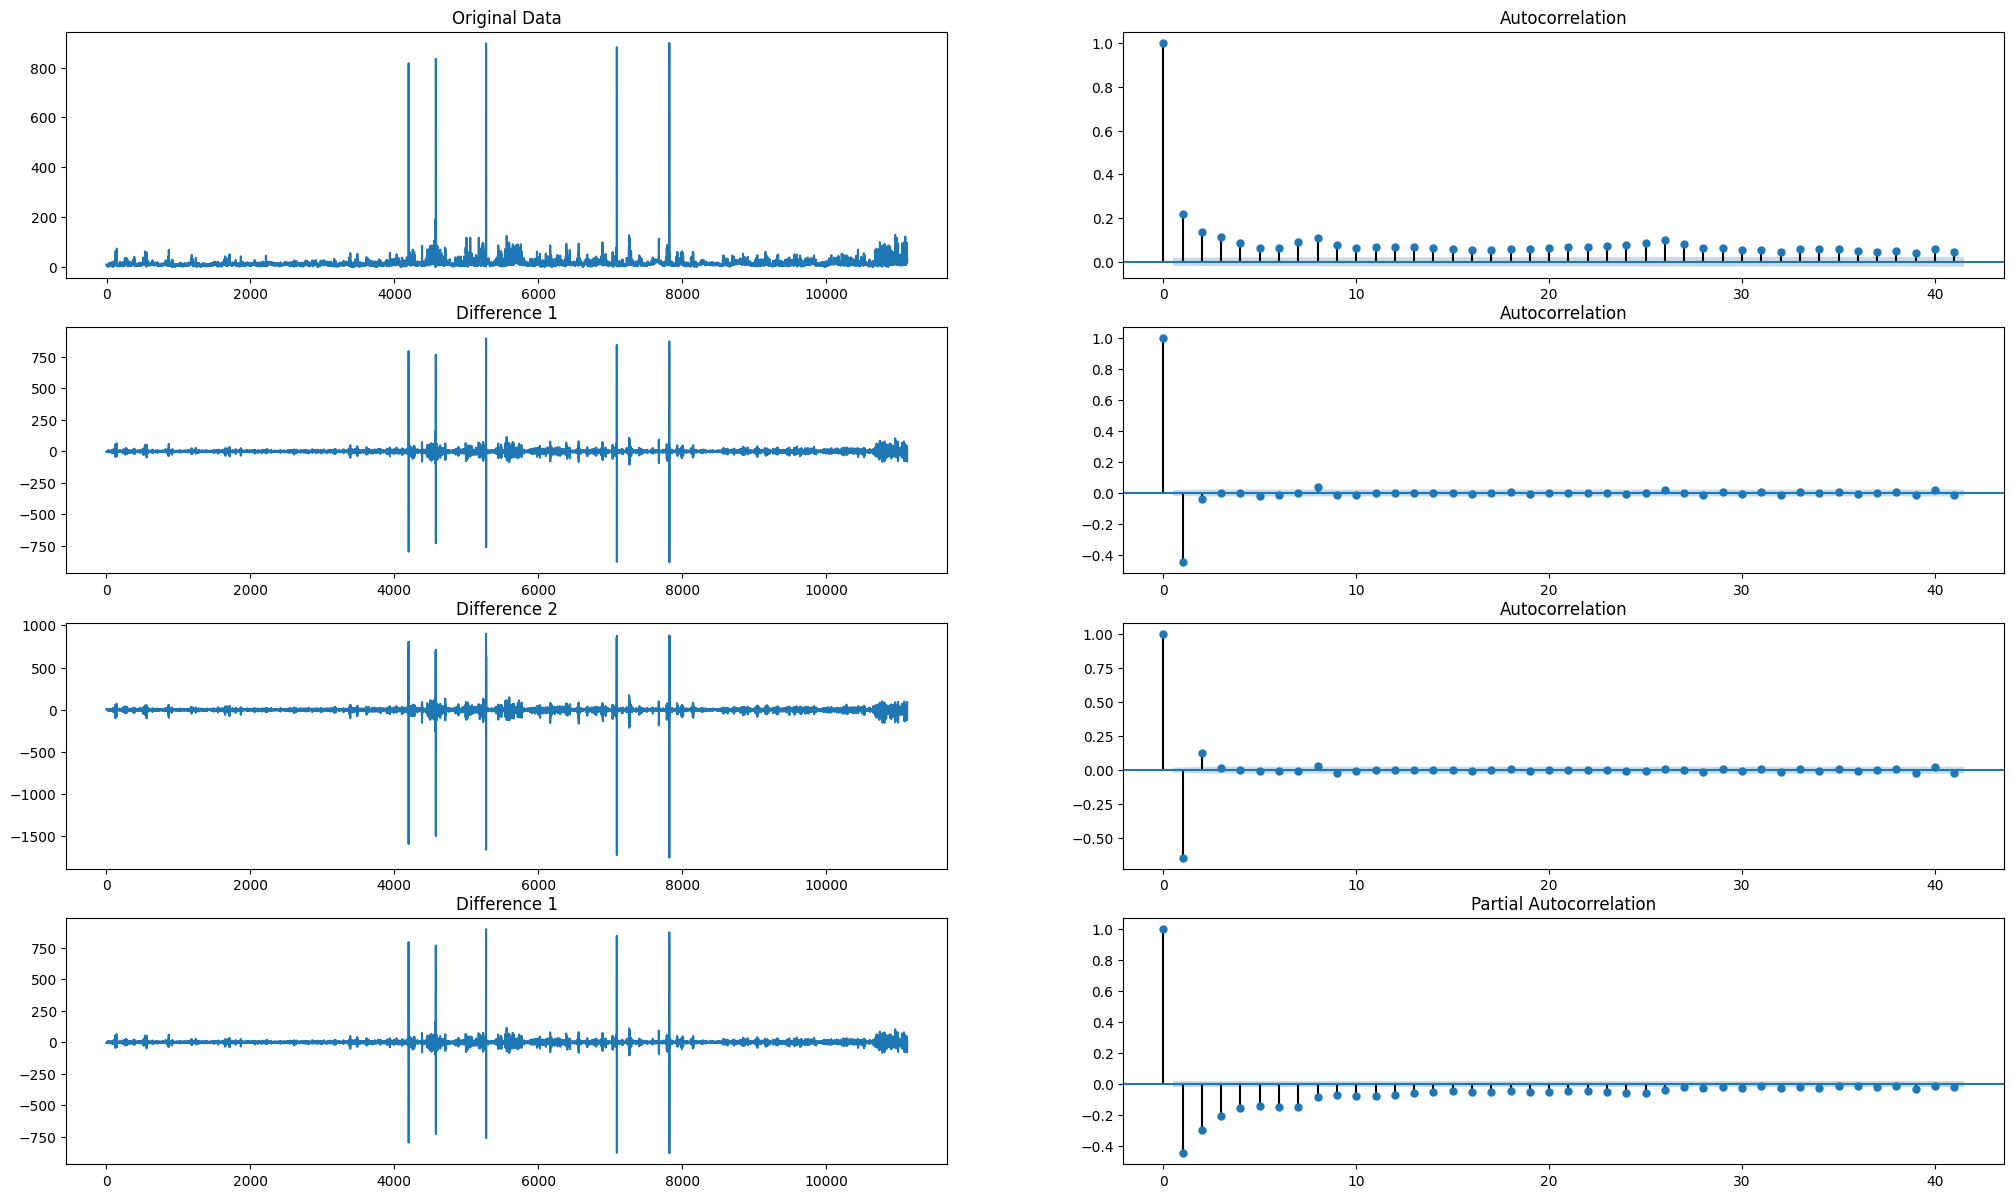

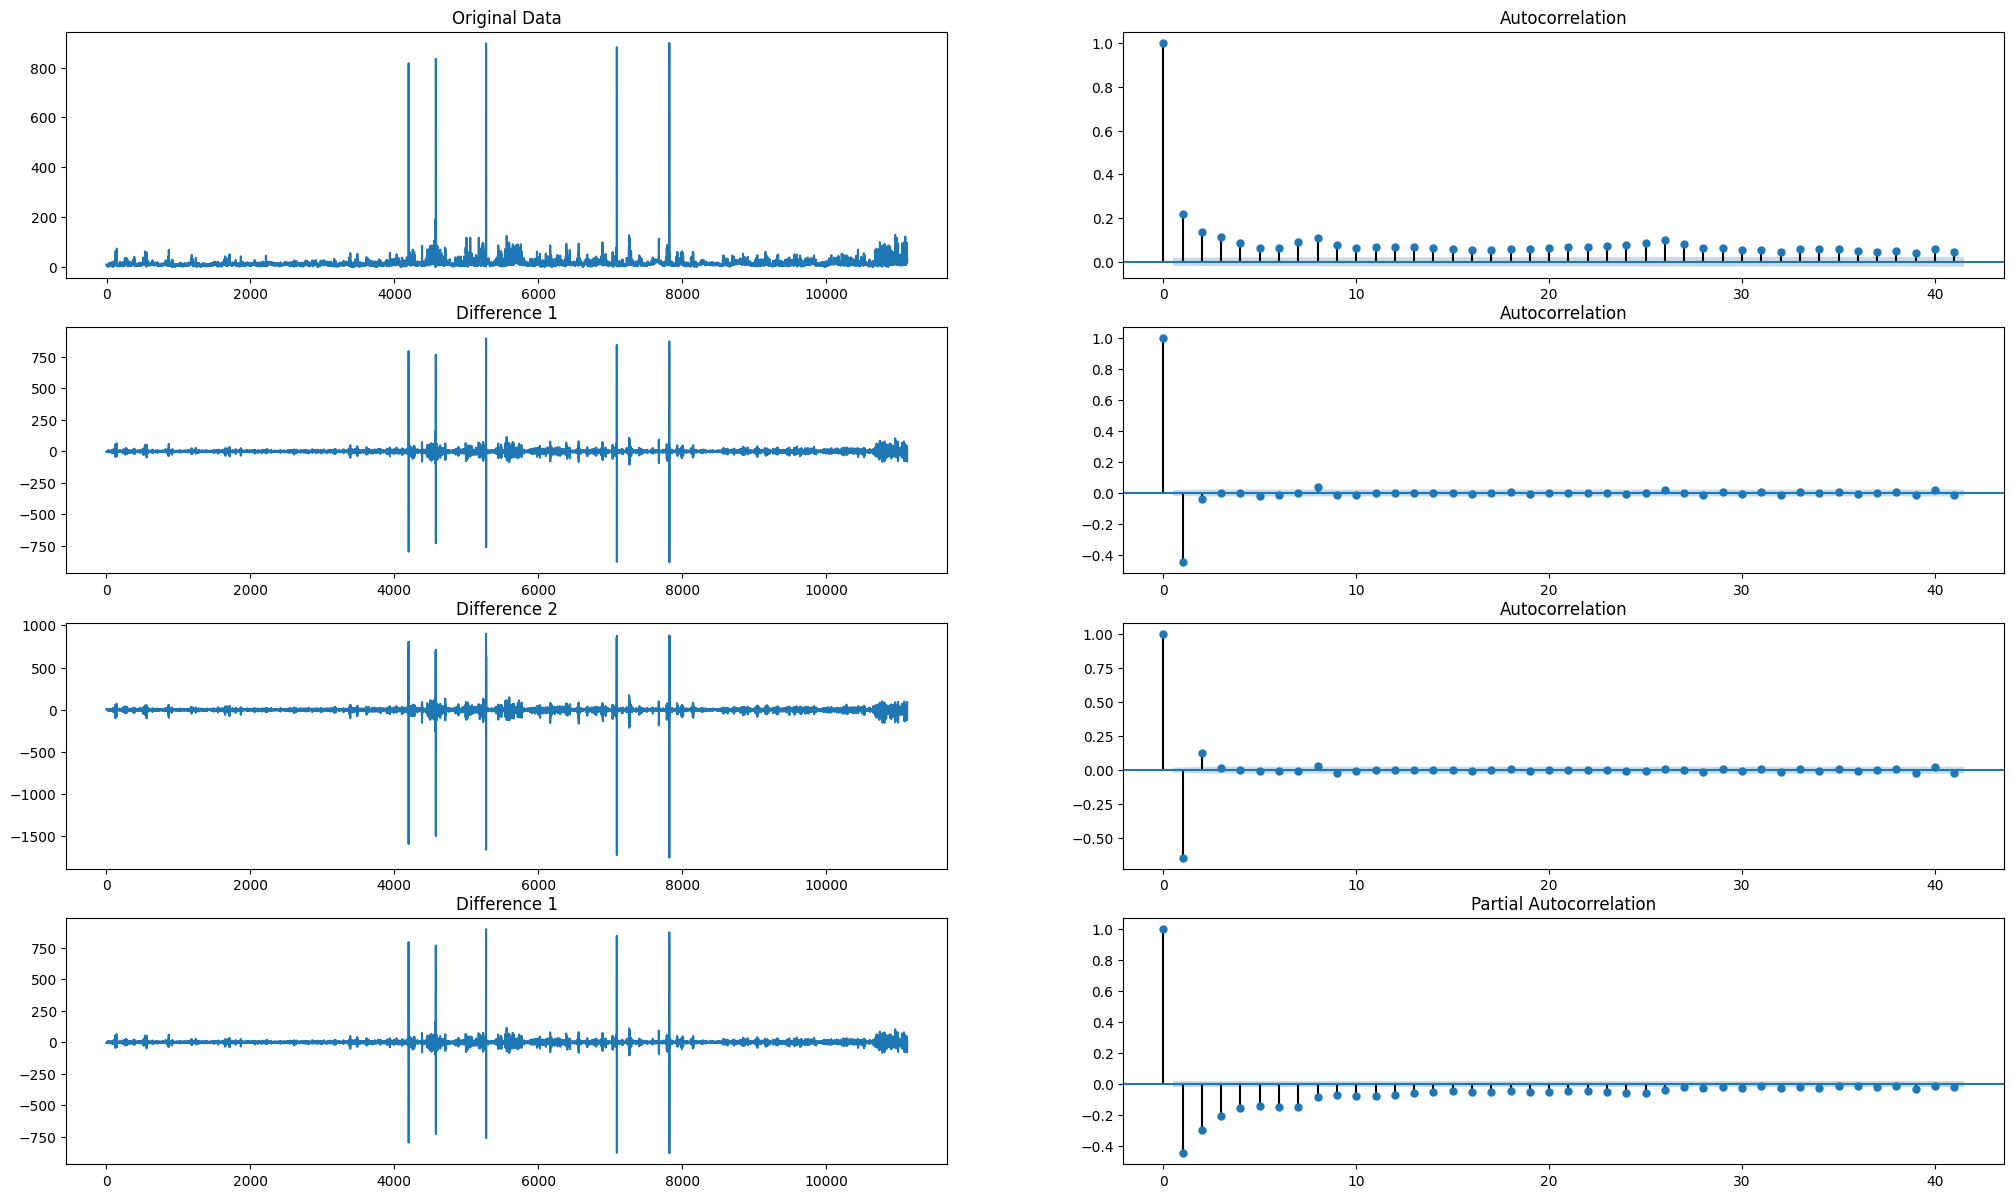

In [159]:
plt.rcParams.update({'figure.figsize':(25,15), 'figure.dpi':100})

# Original Data
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(df_forecast); axes[0, 0].set_title('Original Data')
plot_acf(df_forecast, ax=axes[0, 1])

axes[1, 0].plot(df_forecast.diff()); axes[1, 0].set_title('Difference 1')
plot_acf(df_forecast.diff().dropna(), ax=axes[1, 1])


axes[2, 0].plot(df_forecast.diff().diff()); axes[2, 0].set_title('Difference 2')
plot_acf(df_forecast.diff().diff().dropna(), ax=axes[2, 1])

axes[3,0].plot(df_forecast.diff()); axes[3, 0].set_title('Difference 1')
plot_pacf(df_forecast.diff().dropna(), ax=axes[3,1])

It seems like true value for d must be 0

In [160]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error as mape

ARMA_model = ARIMA(endog=train, order=(1, 0, 3))
ARMA_model = ARMA_model.fit()
predictions = ARMA_model.predict(start=test.index[0], 
                                        end=test.index[-1])
from sklearn.metrics import mean_squared_error
pm_25_arima_results = mean_squared_error(test, predictions, squared =False)
pm_25_arima_results

3.5187843049676104

### ARIMA FOR PM10

In [70]:
pm_10.fillna(0, inplace = True)
df_forecast = pm_10
train, test = pm_10[0:-1], pm_10[-1:]

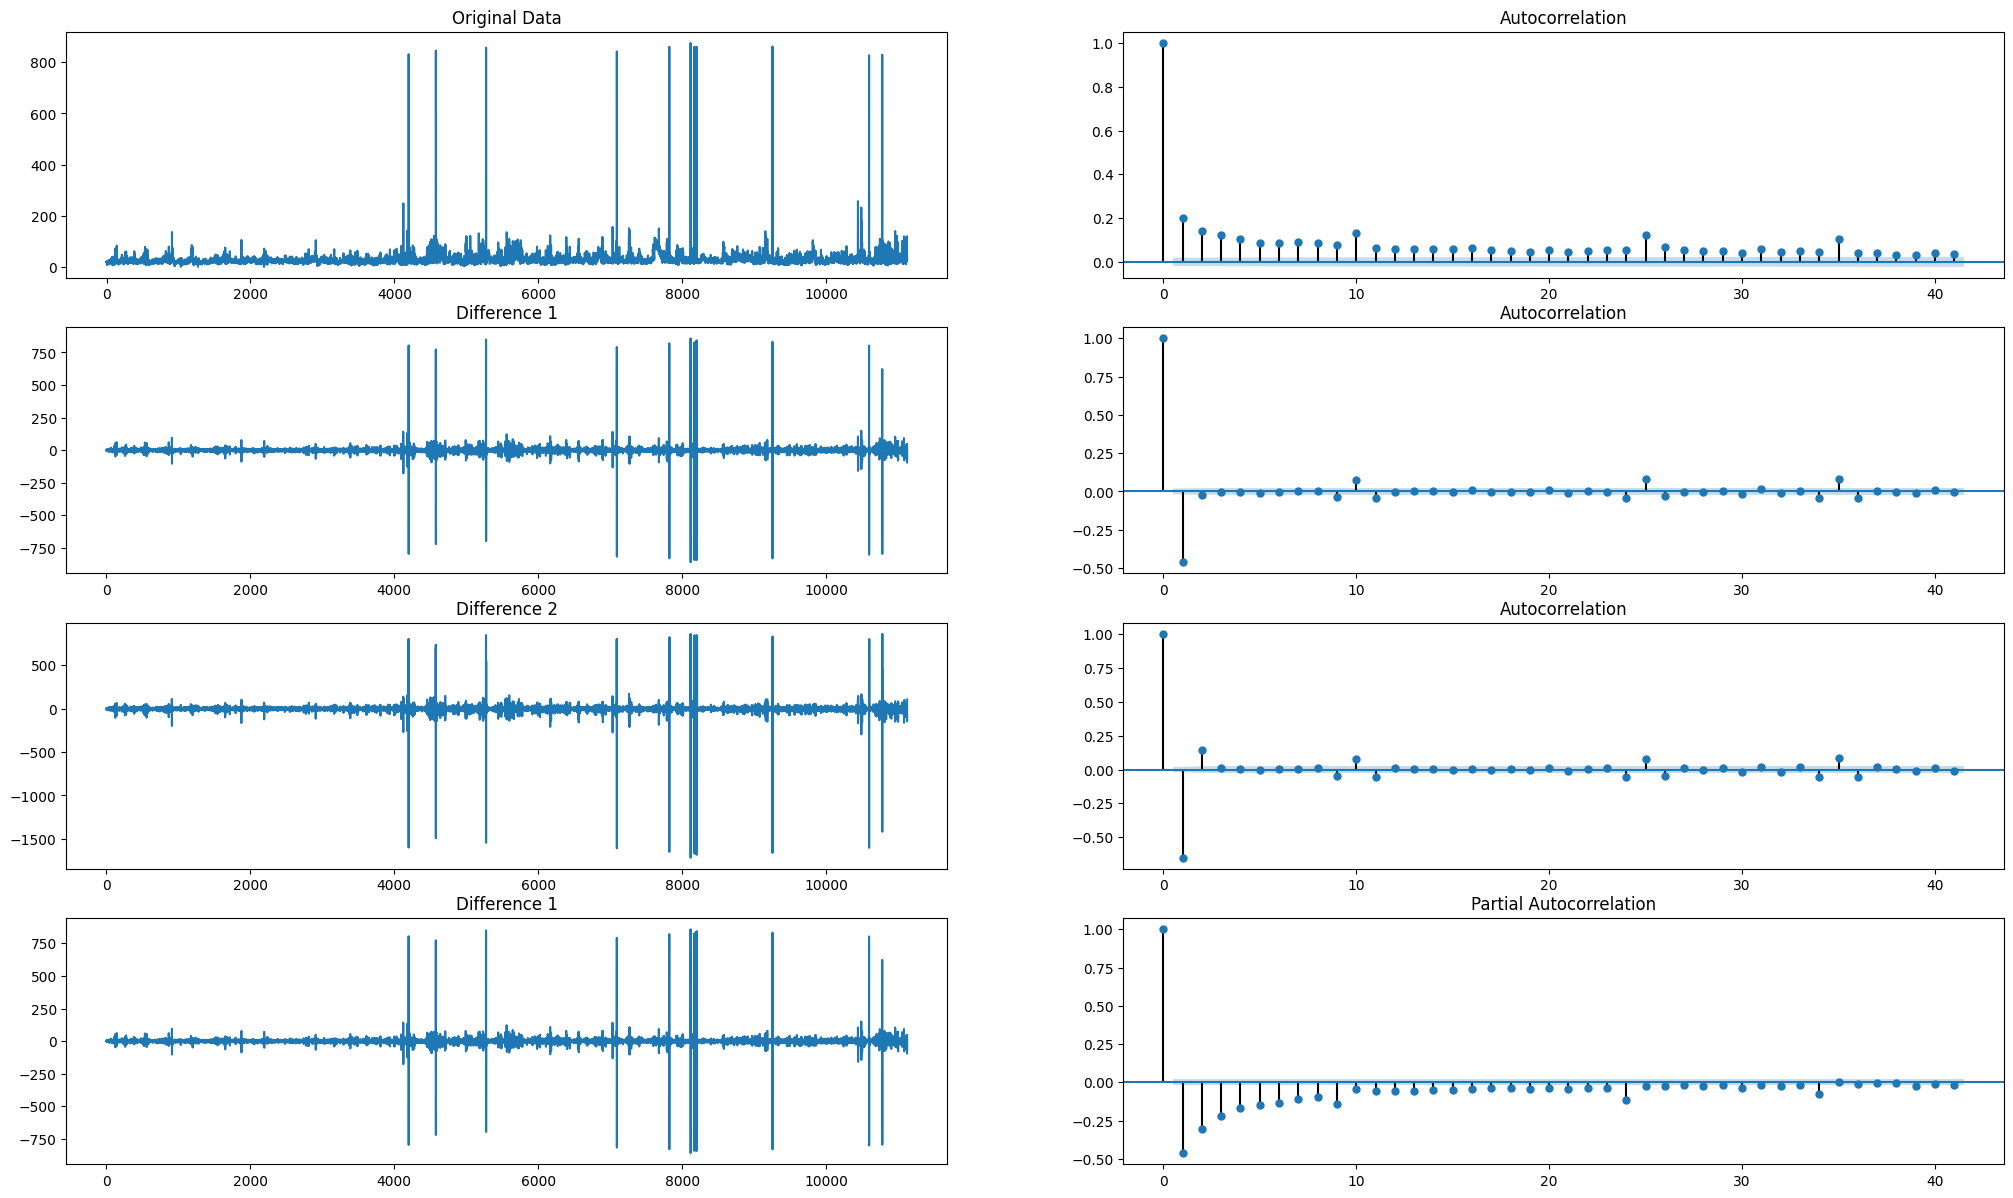

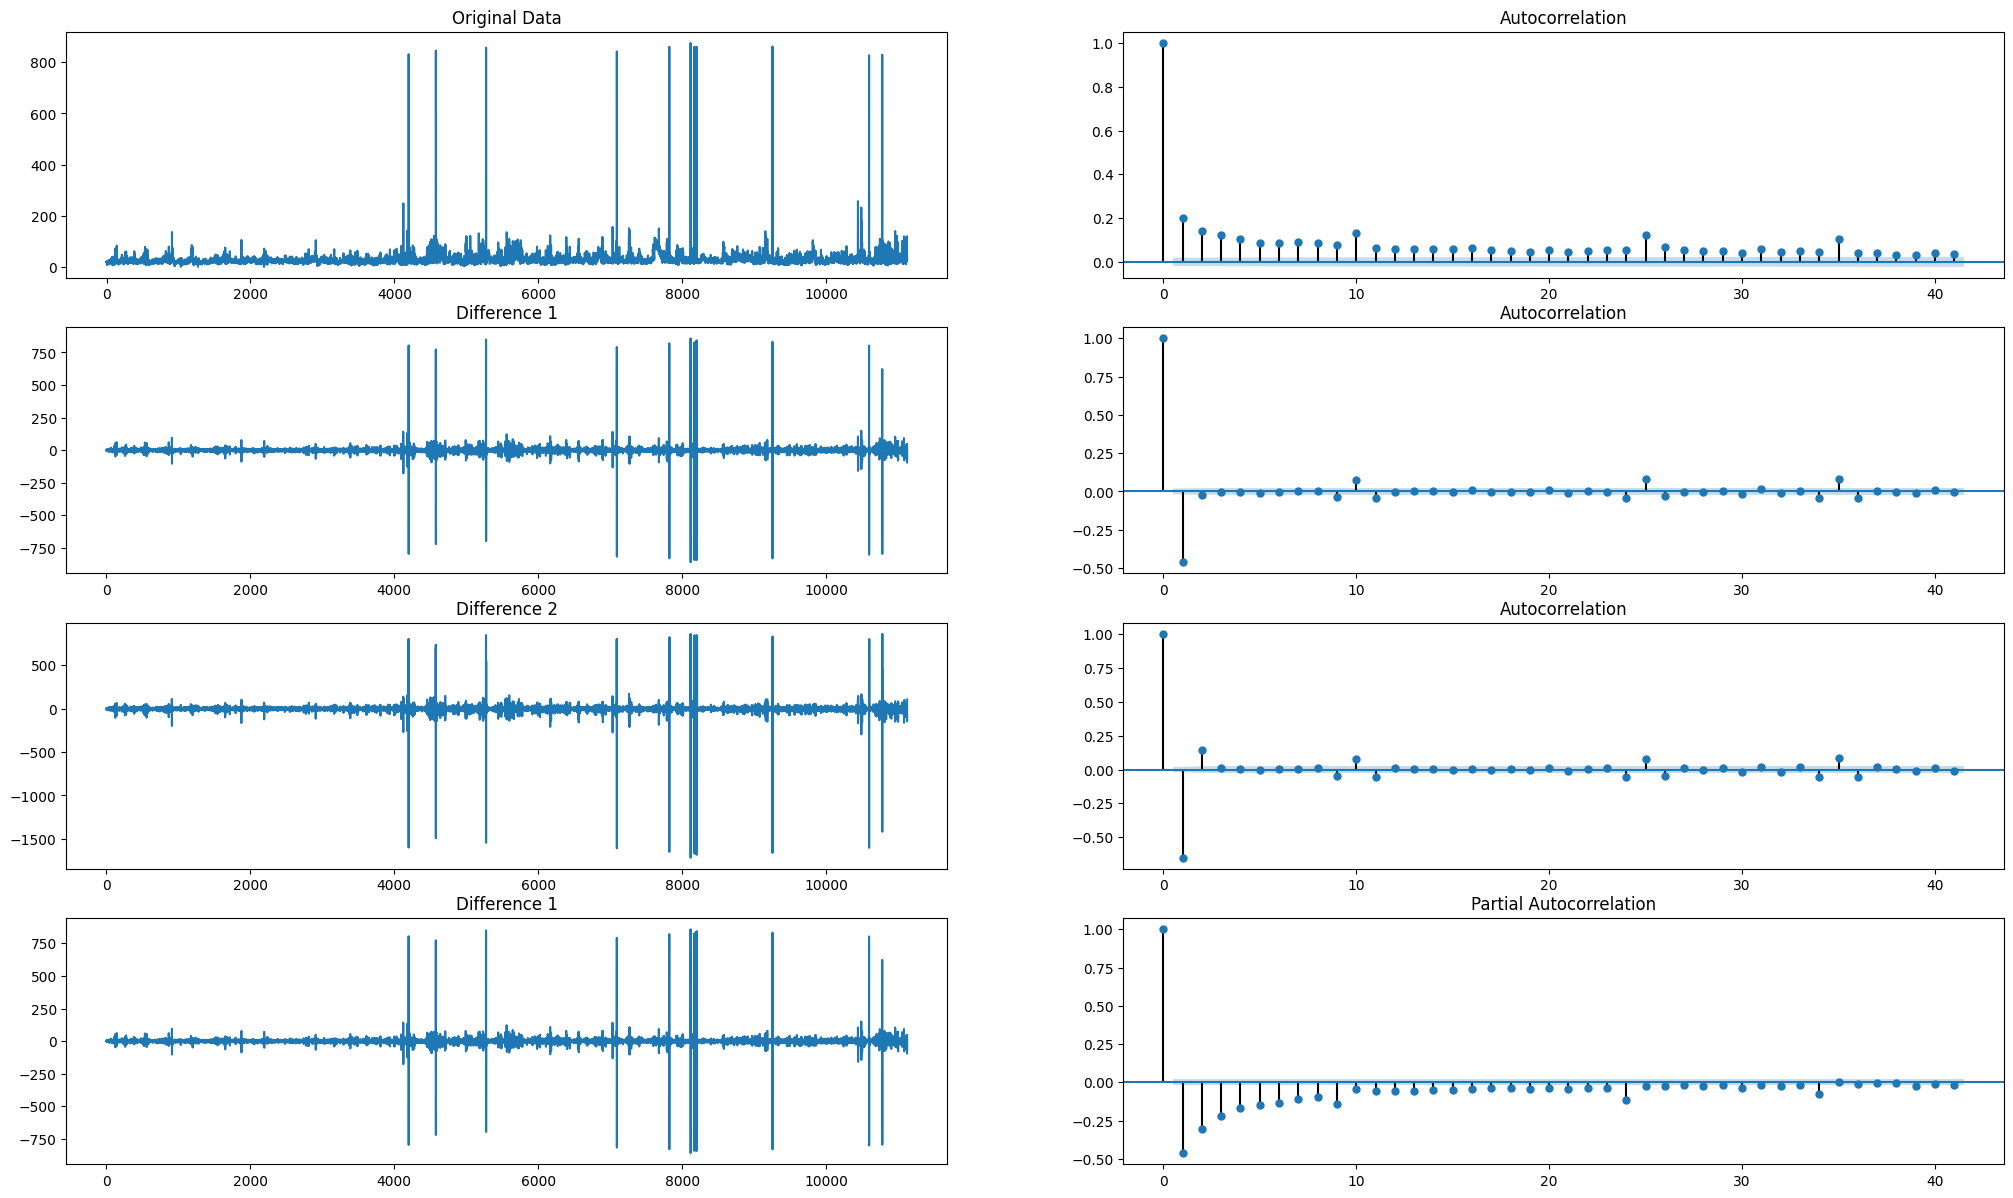

In [71]:
plt.rcParams.update({'figure.figsize':(25,15), 'figure.dpi':100})

# Original Data
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(df_forecast); axes[0, 0].set_title('Original Data')
plot_acf(df_forecast, ax=axes[0, 1])

axes[1, 0].plot(df_forecast.diff()); axes[1, 0].set_title('Difference 1')
plot_acf(df_forecast.diff().dropna(), ax=axes[1, 1])


axes[2, 0].plot(df_forecast.diff().diff()); axes[2, 0].set_title('Difference 2')
plot_acf(df_forecast.diff().diff().dropna(), ax=axes[2, 1])

axes[3,0].plot(df_forecast.diff()); axes[3, 0].set_title('Difference 1')
plot_pacf(df_forecast.diff().dropna(), ax=axes[3,1])

In [74]:
from statsmodels.tsa.arima_model import ARIMA

ARIMA_model = ARIMA(endog=train, order=(1, 0, 3))
ARIMA_model = ARIMA_model.fit()
predictions_arima_pm_10 = ARIMA_model.predict(start=test.index[0], 
                                        end=test.index[-1])
from sklearn.metrics import mean_squared_error
pm_10_arima_result = mean_squared_error(test, predictions_arima_pm_10, squared =False)
pm_10_arima_result

0.06605025297261591

### SVR for PM25

In [77]:
from sklearn.svm import SVR
from pandas import DataFrame, concat

In [78]:
def series_timedep(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(pm_25.to_frame())

reframed = series_timedep(scaled, 1, 2)
train_x, train_y, test_x, test_y = reframed.iloc[:-1, 1:].values, reframed.iloc[:-1, 0].values, reframed.iloc[-1:, 1:].values, reframed.iloc[-1:, 0].values

In [79]:
model_svm = SVR(kernel='rbf', C=5)

model_svm.fit(train_x, train_y)

SVR(C=5)

In [80]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

yhat_svm = model_svm.predict(test_x)
yhat_svm = yhat_svm.reshape((len(yhat_svm), 1))
# invert scaling for forecast
inv_yhat_svm = np.concatenate((yhat_svm, test_x), axis=1)
inv_yhat_svm = scaler.inverse_transform(inv_yhat_svm)
inv_yhat_svm = inv_yhat_svm[:, 0]
# calculate RMSE
pm_25_svr_result = np.sqrt(mean_squared_error(inv_y, inv_yhat_svm))
print('Test RMSE: %.3f' % pm_25_svr_result)

Test RMSE: 1.814


### SVR For PM10

In [154]:
def series_timedep(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(pm_10.to_frame())

reframed = series_timedep(scaled, 1, 7)
train_x, train_y, test_x, test_y = reframed.iloc[:-1, 1:].values, reframed.iloc[:-1, 0].values, reframed.iloc[-1:, 1:].values, reframed.iloc[-1:, 0].values

In [155]:
model_svm = SVR(kernel='rbf', C=50)

model_svm.fit(train_x, train_y)

SVR(C=50)

In [156]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]

yhat_svm = model_svm.predict(test_x)
yhat_svm = yhat_svm.reshape((len(yhat_svm), 1))
# invert scaling for forecast
inv_yhat_svm = np.concatenate((yhat_svm, test_x), axis=1)
inv_yhat_svm = scaler.inverse_transform(inv_yhat_svm)
inv_yhat_svm = inv_yhat_svm[:, 0]
# calculate RMSE
pm_10_svr_result = np.sqrt(mean_squared_error(inv_y, inv_yhat_svm))
print('Test RMSE: %.3f' % pm_10_svr_result)

Test RMSE: 4.314


## Let's compare the results!

#### Let's start with PM25

In [165]:
comparison_df_pm_25 = pd.DataFrame([pm_25_lstm_result, pm_25_hybrid_result, pm_25_svr_result, pm_25_arima_results], columns = ["MSE Loss"])

In [166]:
comparison_df_pm_25.index = ["LSTM", "Hybrid (LSTM+CNN)", "SVM", "Arima"]

In [176]:
comparison_df_pm_25 = comparison_df_pm_25.T
comparison_df_pm_25

,LSTM,Hybrid (LSTM+CNN),SVM,Arima
MSE Loss,3.276777,5.508804,1.814111,3.518784


### Now, PM10

In [170]:
comparison_df_pm_10 = pd.DataFrame([pm_10_lstm_result, pm_10_hybrid_result, pm_10_svr_result, pm_10_arima_result], columns = ["MSE Loss"])

In [172]:
comparison_df_pm_10.index = ["LSTM", "Hybrid (LSTM+CNN)", "SVM", "Arima"]

In [175]:
comparison_df_pm_10 = comparison_df_pm_10.T
comparison_df_pm_10

,LSTM,Hybrid (LSTM+CNN),SVM,Arima
MSE Loss,7.684701,6.978071,4.313564,0.06605


In [178]:
compare_df = pd.concat([comparison_df_pm_10, comparison_df_pm_25])
compare_df ["Pollution Type"] = ["PM10", "PM25"]

In [179]:
compare_df

,LSTM,Hybrid (LSTM+CNN),SVM,Arima,Pollution Type
MSE Loss,7.684701,6.978071,4.313564,0.066050,PM10
MSE Loss,3.276777,5.508804,1.814111,3.518784,PM25


It looks like SVM and Arima are best options to forecast pollution numbers. Then, LONG LIVE SVM and ARIMA!